<a href="https://colab.research.google.com/github/Sudhandar/ResNet-50-model/blob/master/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
import numpy as np
import tensorflow as tf
import h5py
import math

def load_dataset():
    train_dataset = h5py.File('/content/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('/content/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    """
    
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    # Shuffle 
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Partition
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
    Z1 = tf.add(tf.matmul(W1, X), b1)                     
    A1 = tf.nn.relu(Z1)                                   
    Z2 = tf.add(tf.matmul(W2, A1), b2)                   
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                   
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [9]:
!pip install graphviz

In [0]:
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.models import Model, load_model

#from tensorflow.python.keras.utils import plot_model
#from utility_functions import *
from tensorflow.python.keras.initializers import glorot_uniform
#import tensorflow.python.keras.backend as K

#K.set_image_data_format('channels_last')
#K.set_learning_phase(1)

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
    """

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path
    X = Conv2D(filters= F2,kernel_size= (f,f), strides=(1,1),padding='same',name =conv_name_base+'2b',kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name= bn_name_base +'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3,kernel_size= (1,1),strides=(1,1),padding='valid',name =conv_name_base+ '2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3 ,name=bn_name_base +'2c')(X)

    # Adding shortcut value to main path and passing it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
       
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Adding shortcut value to main path and passing it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the  ResNet50 architecture.
    
    """

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters =  [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3,  [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3,  [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

#tf.reset_default_graph()

# model compiling
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
train_dataset = h5py.File('/content/train_signs.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:])
train_set_y_orig = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('/content/test_signs.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

classes = np.array(test_dataset["list_classes"][:]) 

train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))


In [0]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T



In [25]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Train on 1080 samples
Epoch 1/20
1080/1080 [==============================] - 6s 6ms/sample - loss: 1.7376 - accuracy: 0.4870
Epoch 2/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.4892 - accuracy: 0.8167
Epoch 3/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.4302 - accuracy: 0.8500
Epoch 4/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.3132 - accuracy: 0.9130
Epoch 5/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.2924 - accuracy: 0.9139
Epoch 6/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.1629 - accuracy: 0.9481
Epoch 7/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.2199 - accuracy: 0.9324
Epoch 8/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.3302 - accuracy: 0.9111
Epoch 9/20
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.1572 - accuracy: 0.9583
Epoch 10/20
1080/1080 [===================

In [26]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 1s 6ms/sample - loss: 0.2791 - accuracy: 0.9250
Loss = 0.2790559738874435
Test Accuracy = 0.925


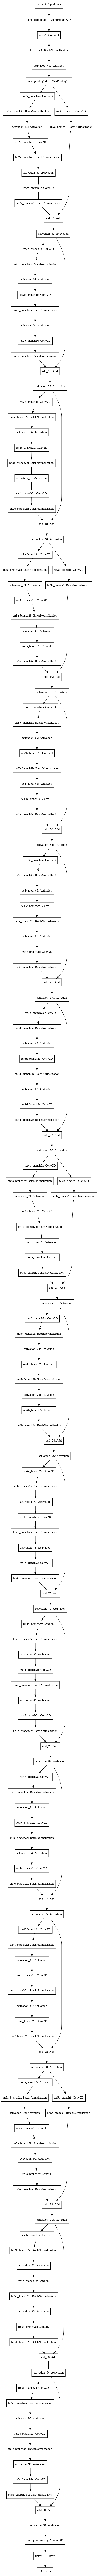

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_architecture.png')


In [31]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________